Has some overlap with the Xarray Guide, but goes more in depth

# Setup

In [88]:
# Import python packages
import xarray as xr #to read file, alter file
import matplotlib as mpl # plotting
import matplotlib.pyplot as plt # plotting

import numpy as np # only needed to run example plots
import math
from datetime import datetime as dt
import time

# Cartopy imports
import cartopy.crs as ccrs # map projections
import cartopy.feature as cfeature # features (eg. borders, lakes)
from cartopy import util as cutil
import cartopy.mpl.ticker as cticker # formatting ticks to be lat/lon

from matplotlib import animation #animations
from matplotlib.widgets import Button, Slider
import warnings

import holoviews as hv
import hvplot.xarray
from holoviews import opts
from holoviews import streams
%matplotlib inline

plt.close('all')

In [70]:
# general dataset
path = 'H:/Summer24-25/' # make sure path uses slashes in //// direction (not '\\\')
filename = 'trends_mad_2005_2015.h0.2014-09.nc'
ds = xr.open_dataset(path+filename) # Read in file as dataset

# dataset for iterating by time
path = 'H:/Summer24-25/'
with warnings.catch_warnings(): #ignore warnings --> else gives fill warning bc some empty values
    warnings.simplefilter('ignore')
    ds_ozone = xr.open_dataset(path+'o3_Amon_CESM2-WACCM_ssp126.nc')

# dataset for using vectors (eg. quiver plots/stream plots)
path = 'H:/Summer24-25/'
with warnings.catch_warnings(): #ignore warnings --> else gives fill warning bc some empty values
    warnings.simplefilter('ignore')
    ds_vectors = xr.open_mfdataset(path+'*WACCM-FV2_historical*.nc')

# converting vector and ozone datasets pressure levels to hPa units (instead of Pa)
for dataset in [ds_vectors, ds_ozone]:
    if dataset.plev.attrs['units'] == 'Pa':
        dataset['plev'] = dataset.plev / 100
        dataset.plev.attrs['axis'] = 'Z' # attributes get reset so have to redo them
        dataset.plev.attrs['positive'] = 'down'
        dataset.plev.attrs['standard_name'] = 'air_pressure'
        dataset.plev.attrs['title'] = 'pressure'
        dataset.plev.attrs['type'] = 'double'
        dataset.plev.attrs['units'] = 'hPa'

In [71]:
# get summary of dataset by stating its name:
ds

<xarray.Dataset> Size: 312MB
Dimensions:       (time: 1, lev: 88, lat: 192, lon: 288, ilev: 89, nbnd: 2,
                   zlon: 1)
Coordinates:
  * ilev          (ilev) float64 712B 4.5e-06 7.42e-06 1.223e-05 ... 985.0 1e+03
  * lat           (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lev           (lev) float64 704B 5.96e-06 9.827e-06 1.62e-05 ... 977.5 992.5
  * lon           (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time          (time) datetime64[ns] 8B 2014-10-01
  * zlon          (zlon) float64 8B 0.0
Dimensions without coordinates: nbnd
Data variables: (12/30)
    BR            (time, lev, lat, lon) float32 19MB ...
    BRCL          (time, lev, lat, lon) float32 19MB ...
    BRO           (time, lev, lat, lon) float32 19MB ...
    BRONO2        (time, lev, lat, lon) float32 19MB ...
    CH4           (time, lev, lat, lon) float32 19MB ...
    CL            (time, lev, lat, lon) float32 19MB ...
    ...            ...
    hyam          (lev) float64 704B ...
    hybi          (ilev) float64 712B ...
    hybm          (lev) float64 704B ...
    time_bnds     (time, nbnd) datetime64[ns] 16B ...
    time_written  (time) |S8 8B ...
    zlon_bnds     (zlon, nbnd) float64 16B ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              trends_mad_2005_2015
    logname:           anderss1
    host:              
    initial_file:      /fmi/datasets/CESM-INPUT/inputdata/atm/cam/inic/fv/f.e...
    topography_file:   /fmi/datasets/CESM-INPUT/inputdata/atm/cam/met/MERRA2/...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1
    history:           Mon Nov 15 12:05:45 2021: ncks -v NOX,NOY,O3,HNO3,CL,C...
    NCO:               netCDF Operators version 4.9.3 (Homepage = http://nco....

In [72]:
# default values: **Load this before any following plots **
timeindex = 0
pressurevalue = 200
default_data = ds.isel(time=timeindex).sel(lev=pressurevalue, method='nearest')

fig_dimensions = (14,9)
projection = ccrs.EqualEarth()
transform = ccrs.PlateCarree()
cmap = 'turbo'
cnorm_o3 = mpl.colors.Normalize(vmin=4*10**-8, vmax=5*10**-7)
cnorm_wind = mpl.colors.Normalize(vmin=0, vmax=65)


def timefmt(timeindex, format='%Y %B'):
    date = dt.strptime(str(ds_ozone.time[timeindex].values), '%Y-%m-%d %H:%M:%S')
    return date.strftime(format)

# Useful Functions

**Saving and Opening:**
* plt.savefig('xxx') or fig.savefig('xxx') --> save figure to file, specify file name and file extension (eg. .png, .pdf, .svg)
* datasetName.to_netcdf('fileName.nc') --> save dataset to netcdf file
* animationName.save('fileName.gif', writer='pillow'); --> save animation as gif
* ds = xr.open_mfdataset('my/files/*.nc', parallel=True) --> open multiple files as one dataset, more at https://docs.xarray.dev/en/stable/user-guide/io.html under 'reading'

**Closing:**
* after loading a plot, plt.close(fig) or plt.close('all') or will run out of memory

In [73]:
#adding new variable--> temperature but in celcius not kelvin
if ds.T.attrs['units'] == 'K':
    ds['T_c'] = ds.T - 273.15 # create new var using old one
    ds.T_c.attrs['units'] = 'celcius' # add units for new var
    ds.T_c.attrs['standard_name'] = 'temperature in celcius' # add name of new var

ds.T_c # get summary new var

if dataset.plev.attrs['units'] == 'Pa':
    dataset['plev'] = dataset.plev / 100
    dataset.plev.attrs['axis'] = 'Z' # attributes get reset so have to redo them
    dataset.plev.attrs['positive'] = 'down'
    dataset.plev.attrs['standard_name'] = 'air_pressure'
    dataset.plev.attrs['title'] = 'pressure'
    dataset.plev.attrs['type'] = 'double'
    dataset.plev.attrs['units'] = 'hPa'

In [74]:
# formatting time
date = dt.strptime(str(ds_ozone.time.isel(time=25).values), '%Y-%m-%d %H:%M:%S')
print('original: %s' %date)
formatted_date = date.strftime('%d %B, %Y') #full list of codes at https://docs.python.org/3/library/datetime.html#format-codes
print('formatted: %s' %formatted_date)

original: 2017-02-14 00:00:00
formatted: 14 February, 2017


# Basic Plots

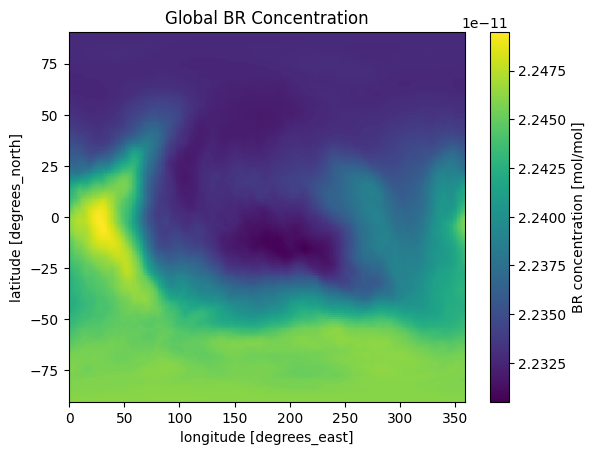

In [7]:
# Use isel (index select) to plot graph using index of coordinates
ds.BR.isel(lev=0, time=timeindex).plot() # plot at first time and pressure level indexes
plt.title('Global BR Concentration') # add title
# To save the plot:
plt.savefig('BR_conc.jpeg') # default img type is png, but can specify by adding .jpeg/pdf/whateverto file name

Text(0.5, 1.0, 'Global Temperatures on 2014-10-01')

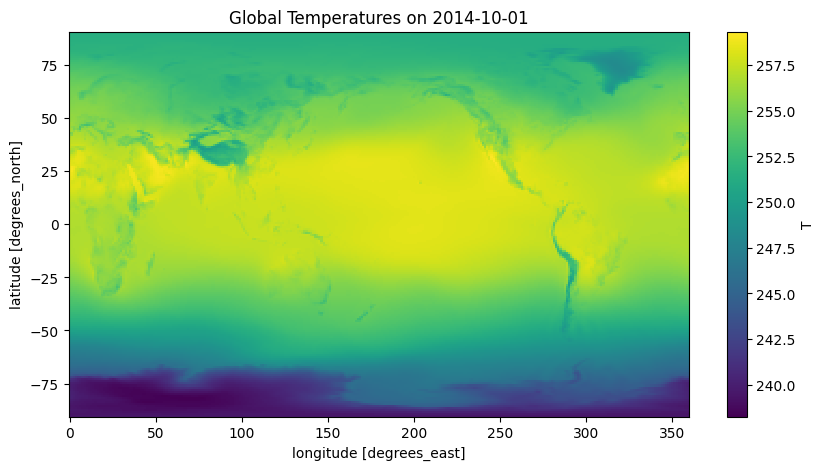

In [8]:
fig = plt.figure(figsize=(10, 5)) # create figure (container) and set size (#pix = size*100)
ax = fig.add_subplot(1, 1, 1) # add a subplot in 1 by 1 grid at pos 1
ds.T.mean(dim='lev').plot(ax=ax) # take average of temperatures at all pressure levels
ax.set_title('Global Temperatures on 2014-10-01')

Text(0.5, 1.0, 'Global Temperatures on 2014-10-01')

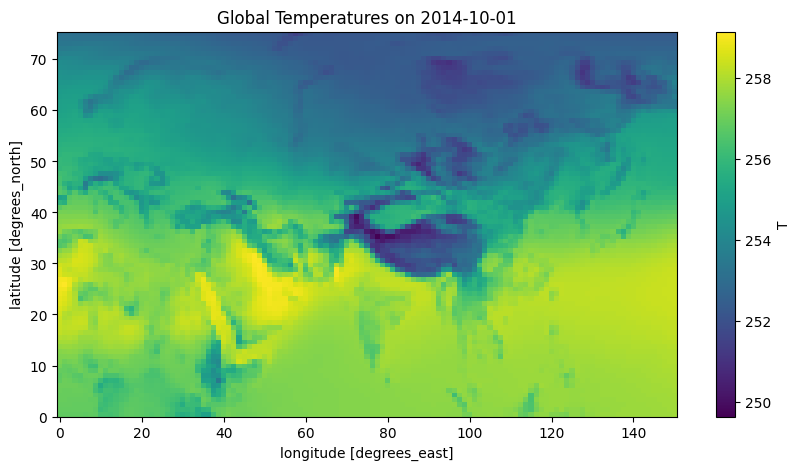

In [9]:
fig, ax = plt.subplots(figsize=(10, 5)) # create figure and an axis (subplot) at same time
ds.T.sel(lon=slice(0,150), lat=slice(0, 75)).mean(dim='lev').plot(ax=ax) # take average of temperatures at all pressure levels, and slice for smaller viewpoint
ax.set_title('Global Temperatures on 2014-10-01')

Text(0.5, 1.0, 'CLO concentration')

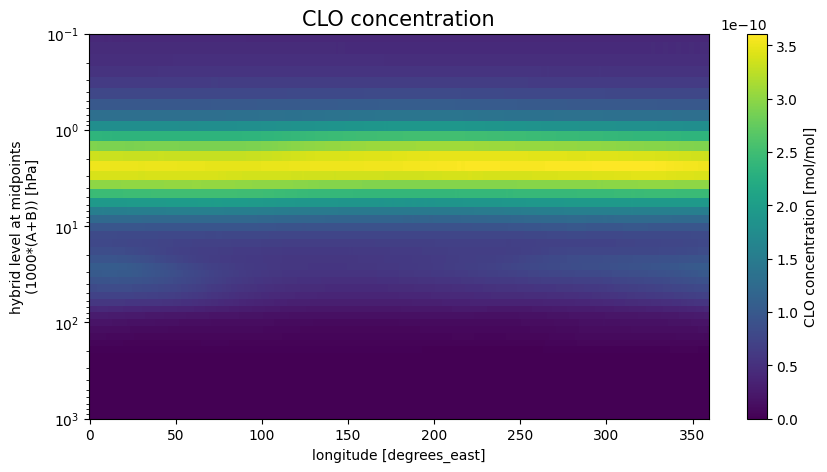

In [10]:
fig,ax = plt.subplots(figsize=[10,5])
cbar_label = ds.CLO.attrs['long_name'] + ' [' + ds.CLO.attrs['units'] + ']'
ds.CLO.isel(time=timeindex).mean(dim='lat').plot(ax=ax, ylim=0.1, cbar_kwargs={'label': cbar_label})
plt.ylim(plt.ylim()[::-1]) # inverting y axis
plt.yscale('log') # using log scale on y axis
ax.set_title('CLO concentration', size=15)

# Contour Plots

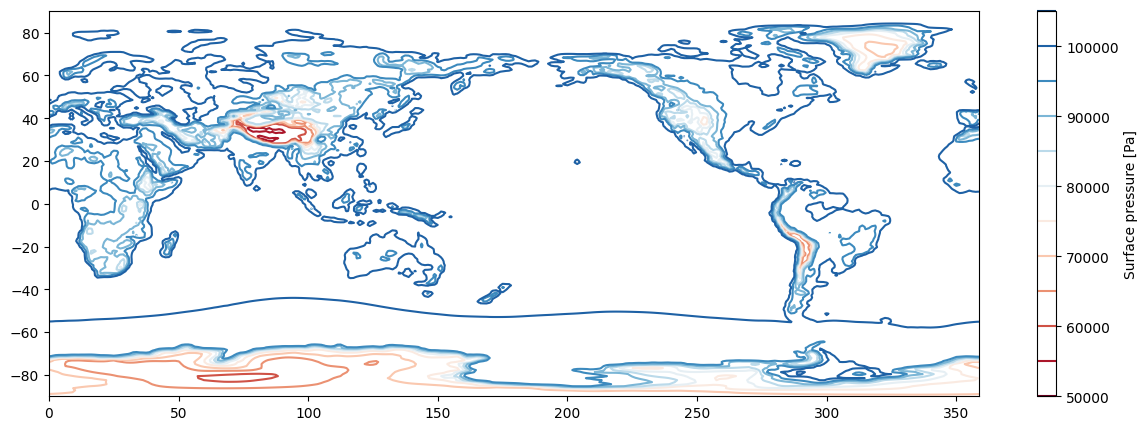

In [11]:
# Contour filled plot
fig=plt.figure(figsize=[15,5])
ax=plt.axes()

cbar_label = ds.PS.attrs['long_name'] + ' [' + ds.PS.attrs['units'] + ']'

cs = ax.contour(ds.lon, ds.lat, ds.PS.isel(time=timeindex), cmap='RdBu', levels=9)
plt.colorbar(cs, label = cbar_label, ax=ax)

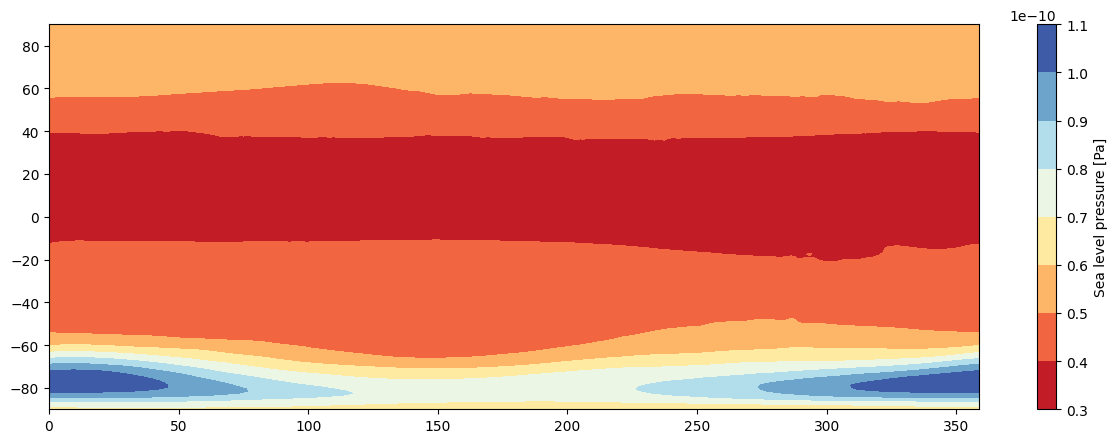

In [12]:
# contour plot
fig=plt.figure(figsize=[15,5])
ax=plt.axes()

cbar_label = ds.PSL.attrs['long_name'] + ' [' + ds.PSL.attrs['units'] + ']'

cs = ax.contourf(ds.lon, ds.lat, ds.CLO.isel(time=timeindex).mean(dim='lev'), cmap='RdYlBu', levels=8)

plt.colorbar(cs, label = cbar_label, ax=ax)

# Using cartopy

IMPORTANT: if there is a download error when using cartopy features, go to https://www.naturalearthdata.com/downloads/ or urls specified in error and download required files. Extract all files in /.local/share/cartopy/shapefiles/natural_earth/ and then physical or cultural depending on the feature.

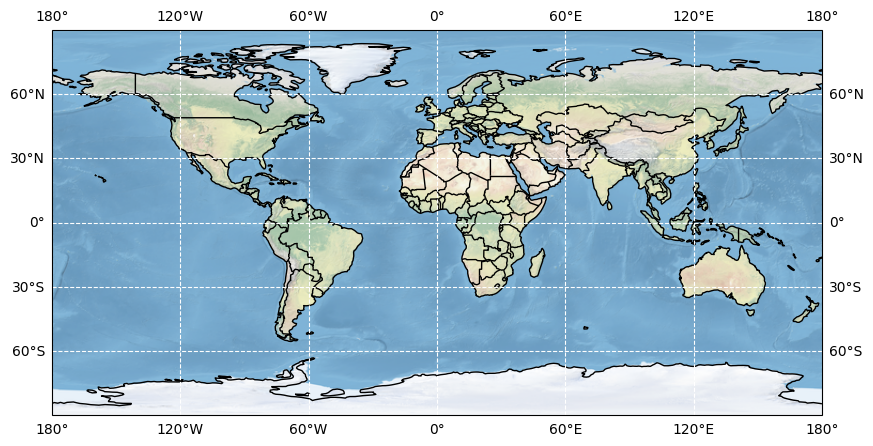

In [13]:
fig=plt.figure(figsize=(10,5))
ax=plt.axes(projection=ccrs.PlateCarree()) # projection wanted
ax.stock_img()
ax.gridlines(color='w', linestyle='--', draw_labels=True) # grid, with longitude/latitude axes labelled
ax.coastlines(color='k') #outline of land
ax.add_feature(cfeature.BORDERS) # divide land into countries

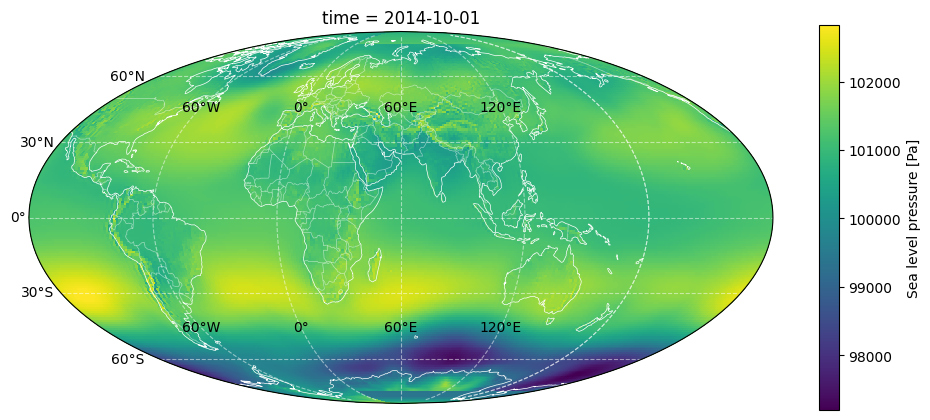

In [14]:
fig = plt.figure(figsize=(12,5))
ax = plt.axes(projection=ccrs.Mollweide(central_longitude=60)) # projection wanted, can also specify central longitude
ax.coastlines(resolution='110m', color='w', lw=0.5)
ax.add_feature(cfeature.BORDERS, lw=0.5, ec='w', alpha=0.5);
ax.gridlines(ls='--', color='w', draw_labels=True, alpha=0.5)
ds.PSL.isel(time=timeindex).plot(ax=ax, transform=ccrs.PlateCarree()) # projection coords are in (always PlateCarree if in lat/longitude)

Text(0.5, 1.0, 'Concentration of total nitrogen around world')

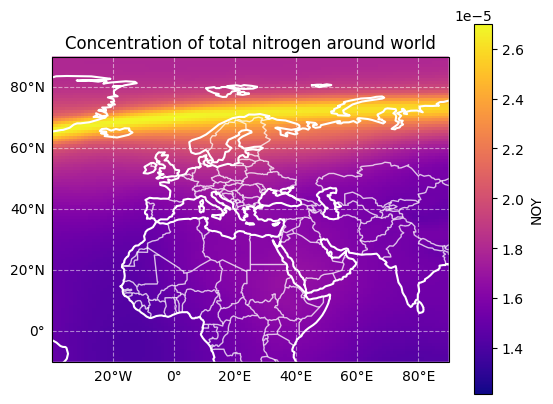

In [15]:
ax = plt.axes(projection=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, color='w', ls='--', alpha=0.5)
gl.top_labels = False # remove grid labels at top
gl.right_labels = False # and to right of plot

ax.coastlines(resolution='110m', color='w', lw=1.5) # add country outlines
ax.add_feature(cfeature.BORDERS, ec='w', alpha=0.75) #add borders

ax.set_extent([-40,90, -10, 95], crs=ccrs.PlateCarree()) # display smaller area--[minlon, maxlon, minlat, maxlat]

ds.NOY.isel(time=timeindex).mean(dim='lev').plot(cmap='plasma', ax=ax, transform=ccrs.PlateCarree()) #plot graph

ax.set_title('Concentration of total nitrogen around world')

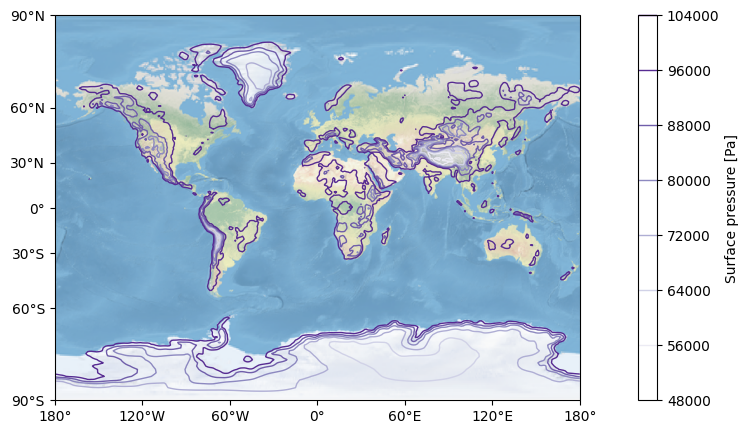

In [16]:
# Contour filled plot
fig=plt.figure(figsize=[15,5])
ax=plt.axes(projection=ccrs.Miller())

data, lons = cutil.add_cyclic_point(ds.PS.isel(time=timeindex), coord=ds.lon) #else would be a white line in middle
cbar_label = ds.PS.attrs['long_name'] + ' [' + ds.PS.attrs['units'] + ']'
ax.stock_img()
cs = ax.contour(lons, ds.lat, data, cmap='Purples', levels=7, transform=ccrs.PlateCarree(), linewidths=1)
plt.colorbar(cs, label = cbar_label, ax=ax)

ax.set_xticks([-180,-120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())

ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

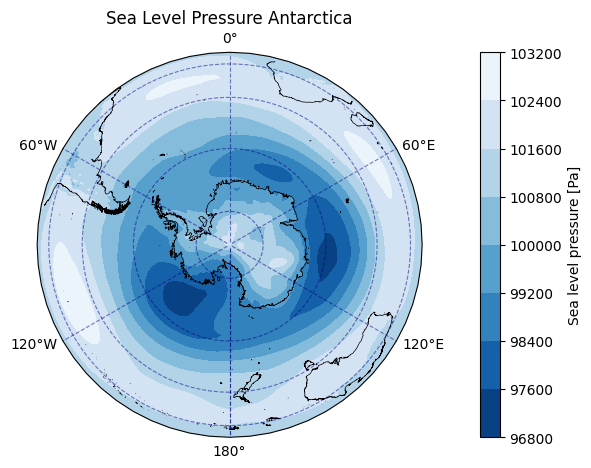

In [17]:
fig=plt.figure(figsize=[15,5])

# Orthographic
ax=plt.axes(projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=-90))


# # Antarctic Stereo - similar to orthographic if use set_extent
# ax=plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0.0))
# ax.set_extent([0,360, -90, -30], ccrs.PlateCarree())
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpl.path.Path(verts * radius + center)
# ax.set_boundary(circle, transform=ax.transAxes)


# contour coloured map
data, lons = cutil.add_cyclic_point(ds.PSL.isel(time=timeindex), coord=ds.lon) #else would be a white line in middle
cs = ax.contourf(lons, ds.lat, data, transform=ccrs.PlateCarree(), cmap='Blues_r')
plt.colorbar(cs, label = ds.PSL.attrs['long_name'] + ' [' + ds.PSL.attrs['units'] + ']')

# # normal coloured plot
# cs = ds.PSL.isel(time=timeindex).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues_r')


ax.set_title('Sea Level Pressure Antarctica')
ax.coastlines(color='k', resolution='10m', lw=0.5)
grid = ax.gridlines(ls='--', color='navy', alpha=0.5, draw_labels=True)

Go to https://scitools.org.uk/cartopy/docs/latest/reference/projections.html for full list of map projections

Times taken to load simple map with coastlines and gridlines in each projection (times taken using %%timeit)
* Circular projections:
* Orthographic= 87.5 ms ± 3.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
* NearsidePerspective= 96.5 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
* Geostationary= 104 ms ± 4.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
* SouthPolarStereo = 1.51 s ± 57.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each
*
* Square/Rectangle projections:
* PlateCarree= 418 ms ± 4.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) --> basic lat/lon
* Mercator= 1.12 s ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* Miller= 1.51 s ± 64.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* LambertCylindrical= 1.31 s ± 38.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* 
* Oval
* Mollweide= 2.85 s ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* Robinson= 4.22 s ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each
* EqualEarth = 4.13 s ± 68.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each

# Subplots

Text(0.5, 1.0, 'CLO conc, 2014-10-01')

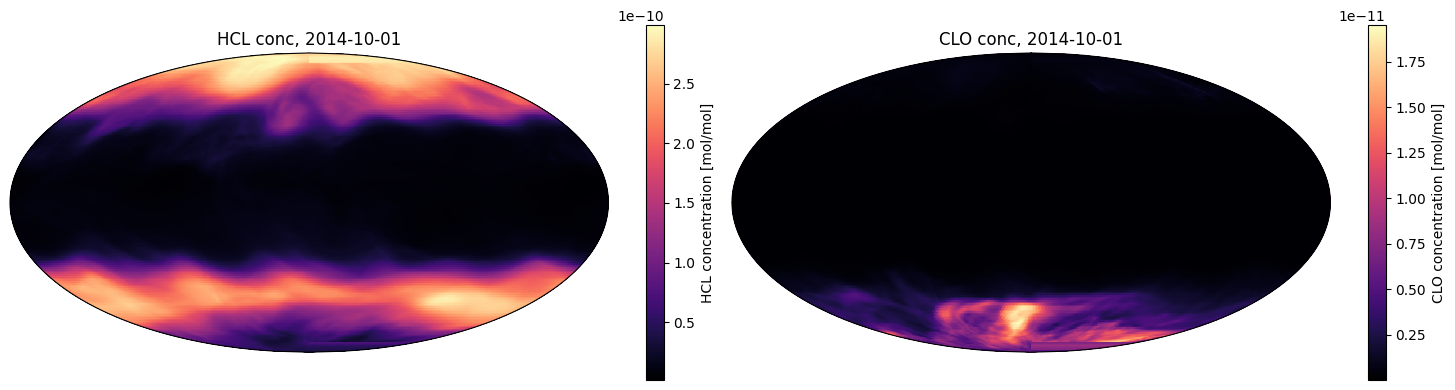

In [18]:
# First example of subplots
fig,(ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=[15,4], layout='tight', subplot_kw=
                              {'projection': ccrs.Mollweide()}) # create container and subcontainers in one line

default_data.HCL.plot(ax=ax1, cmap='magma', transform=ccrs.PlateCarree())
ax1.set_title('HCL conc, 2014-10-01')

default_data.CLO.plot(ax=ax2, cmap='magma', transform=ccrs.PlateCarree())
ax2.set_title('CLO conc, 2014-10-01')

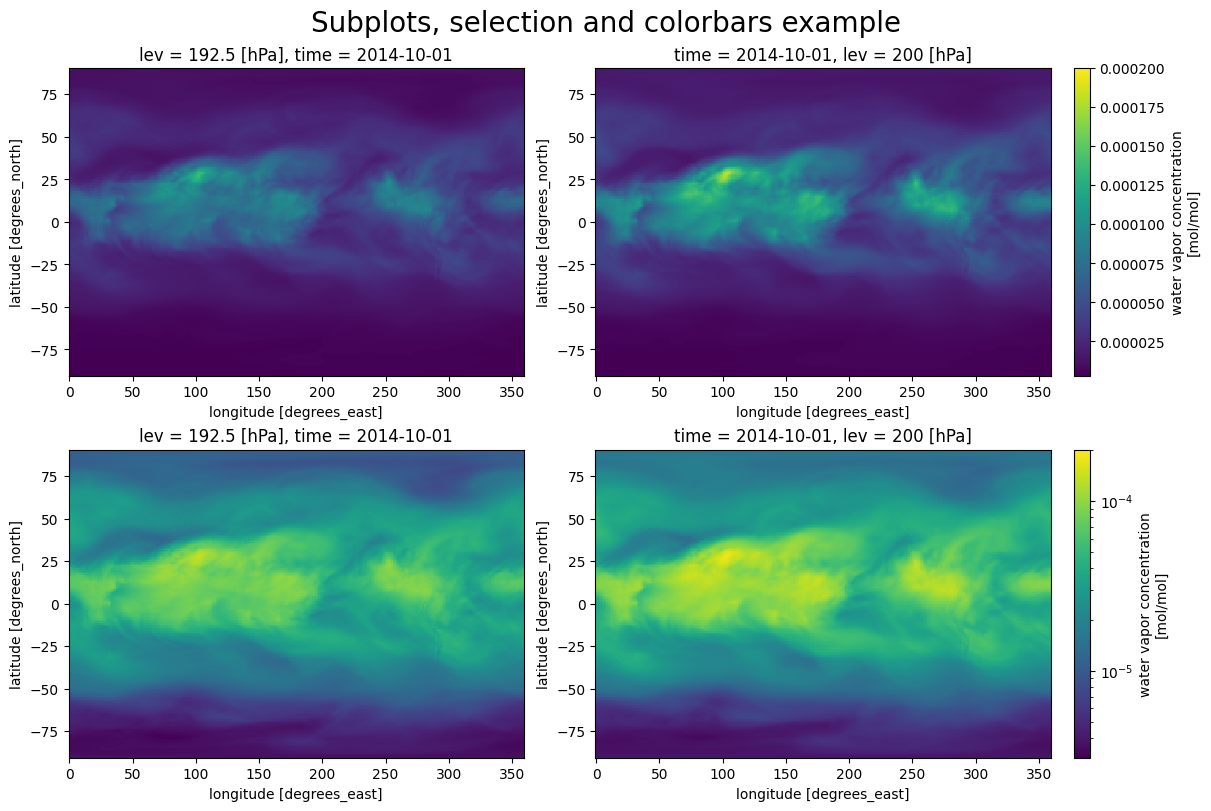

In [19]:
# Second example of subplots
fig,axs = plt.subplots(nrows=2,ncols=2, figsize=[12,8], layout='constrained') # 'constrained' layout prevents overlap of labels
fig.suptitle('Subplots, selection and colorbars example', size=20)

# Normalising colour map between graphs--> can use different types of normalizing
norm = mpl.colors.Normalize(vmax=0.0002)
lognorm = mpl.colors.LogNorm(vmax=0.0002)

# Selection methods
ds.H2O.sel(time='2014-10-30', lev=pressurevalue, method='nearest').plot(ax=axs[0,0], norm=norm, add_colorbar=False)
                                    # sets lev to closest valid value       # remove first colorbar, as second will be identical

ds.H2O.isel(time=timeindex).interp(lev=pressurevalue).plot(ax=axs[0,1], norm=norm) # interpolation to set lev to 200

# same but uses lognorm on colorbar
ds.H2O.sel(time='2014-10-30', lev=pressurevalue, method='nearest').plot(ax=axs[1,0], norm=lognorm, add_colorbar=False)
                                                                            # remove first colorbar, as second will be identical

ds.H2O.isel(time=timeindex).interp(lev=pressurevalue).plot(ax=axs[1,1], norm=lognorm)


Text(0.5, 0.5, 'e')

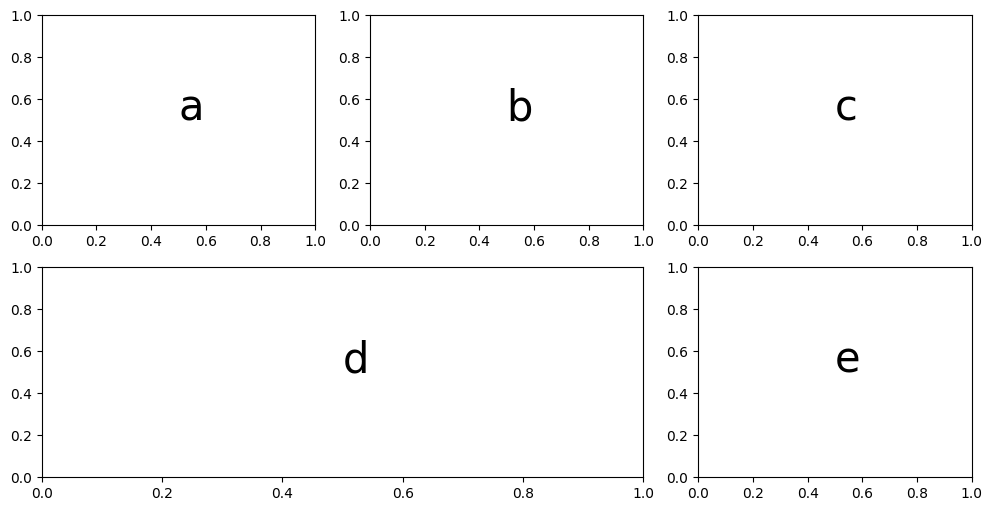

In [20]:
# subplot mosaic: easiest way to make complicated subplot grids
fig = plt.figure(figsize=(12,6))

# mosaic = (
#     [
#         ["a", ".", "b"],
#         ["c", "c", "b"],
#         ["d", "e", "e"],
#     ]
# )
mosaic = '''abc
            dde'''

# mosaic = 'abc;dbc;dee'

axs = fig.subplot_mosaic(mosaic)

axs['a'].annotate('a', xy=[0.5,0.5], size=30)
axs['b'].annotate('b', xy=[0.5,0.5], size=30)
axs['c'].annotate('c', xy=[0.5,0.5], size=30)
axs['d'].annotate('d', xy=[0.5,0.5], size=30)
axs['e'].annotate('e', xy=[0.5,0.5], size=30)

<Axes: >

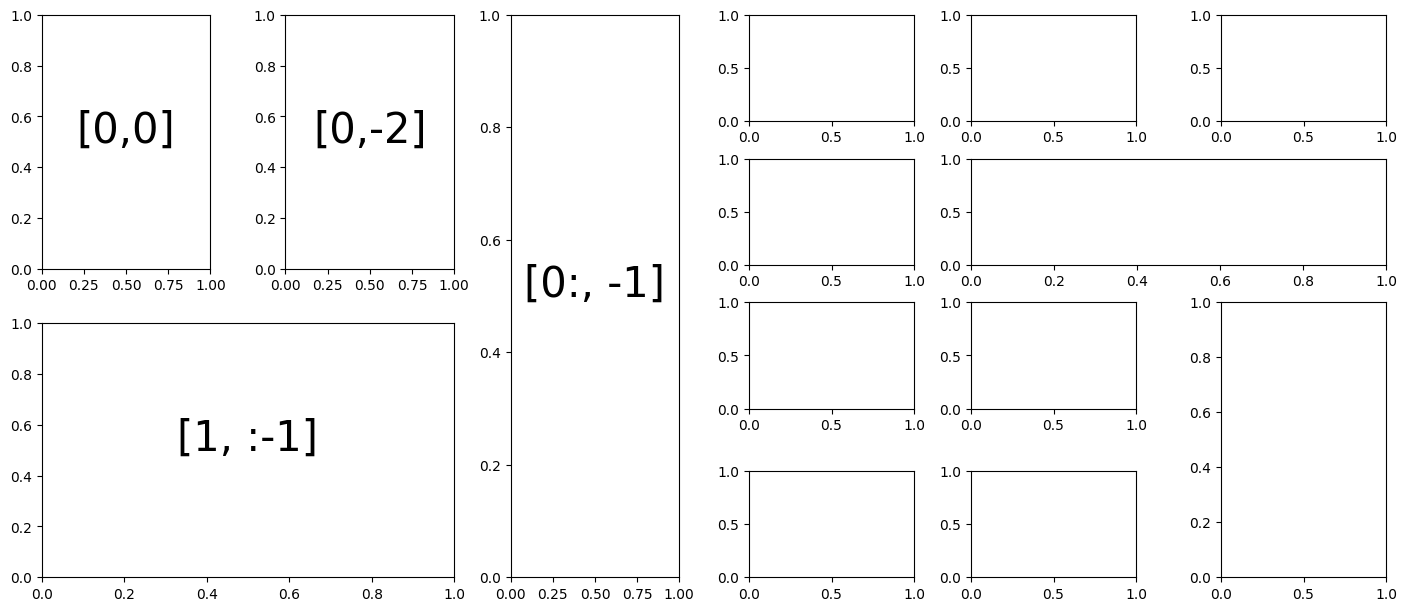

In [21]:
# subfigures
fig = plt.figure(figsize=(14,6), layout='constrained')
left,right = fig.subfigures(nrows=1,ncols=2)

# Gridspec: use for more complex subplots

# use gridspec to create larger plots
grid = left.add_gridspec(ncols=3, nrows=2, figure=left)
ax1 = left.add_subplot(grid[0,0]).annotate('[0,0]', xy=[0.5,0.5], size=30, ha='center')
ax2 = left.add_subplot(grid[0,-2]).annotate('[0,-2]', xy=[0.5,0.5], size=30, ha='center')
ax3 = left.add_subplot(grid[1, :-1]).annotate('[1, :-1]', xy=[0.5,0.5], size=30, ha='center')
ax4 = left.add_subplot(grid[0:, -1]).annotate('[0:, -1]', xy=[0.5,0.5], size=30, ha='center')


# use subplots as a base, then remove some and use gridspec to create larger ones
axs = right.subplots(4,3)
grid = axs[-2,-1].get_gridspec()
for ax in axs[1, 1:]:
    ax.remove()
right.add_subplot(grid[1, 1:])
for ax in axs[-2:, -1]:
    ax.remove()
right.add_subplot(grid[-2:,-1])

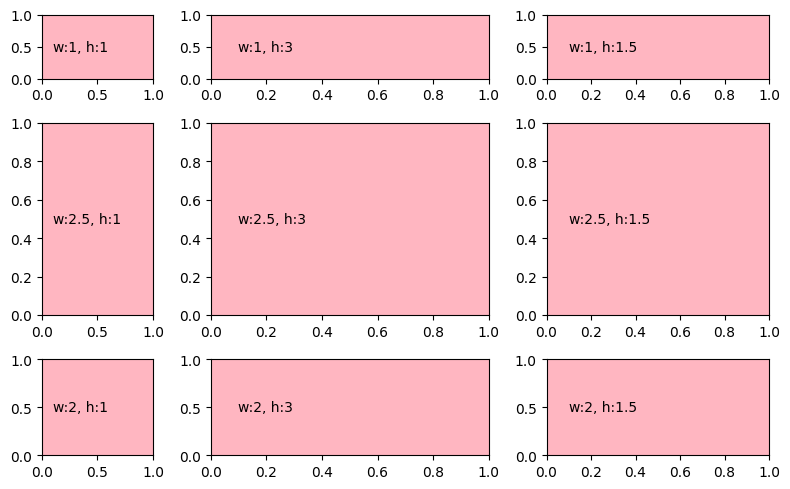

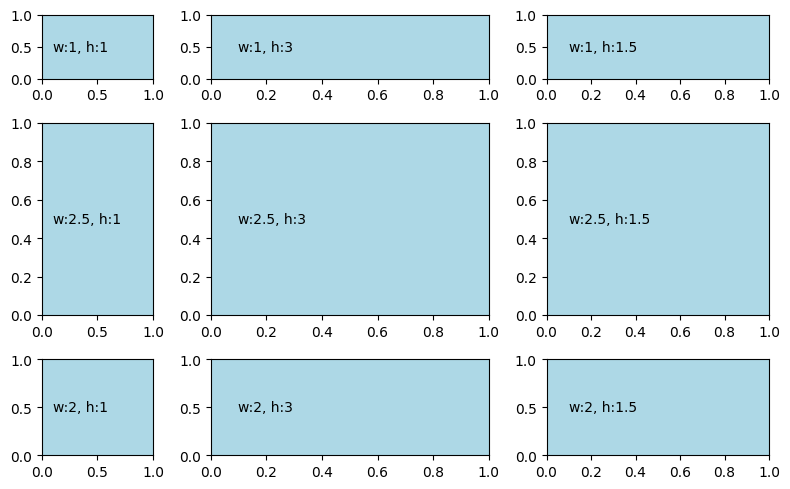

In [22]:
w=[1, 2.5, 2]
h=[1, 3, 1.5]

# More gridspec examples
fig = plt.figure(figsize=(8,5), layout='tight')
grid = fig.add_gridspec(ncols=3, nrows=3, width_ratios=w, height_ratios=h)

for r in range(len(w)):
    for c in range(len(h)):
        ax = fig.add_subplot(grid[r,c])
        ax.annotate('w:%s, h:%s' %(w[r], h[c]), (0.1, 0.5), xycoords='axes fraction', va='center')
        ax.set_facecolor('lightpink')


# same layout as above, but simpler code and ability to easily access axs later
fig, axs = plt.subplots(3,3, gridspec_kw = dict(width_ratios=w, height_ratios=h), figsize=(8,5), layout='tight')
for r, row in enumerate(axs):
    for c, ax in enumerate(row):
        ax.annotate('w:%s, h:%s' %(w[r], h[c]), (0.1, 0.5), xycoords='axes fraction', va='center')
        ax.set_facecolor('lightblue')

In [54]:
%%time
# variable size of subplot grid
times = np.arange(9,12*12+9, 12) # looking for one plot per year, in the 10th month (index 9) --> using ozone data as it has time variable
times = np.arange(0,12,1)
row,col = math.ceil(len(times)**0.5), round(len(times)**0.5)

fig, axs = plt.subplots(row,col, figsize=(col*5, row*5), subplot_kw=
                        {'projection': ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=-90)})
fig.suptitle('ozone concentration', size=20)
fig.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.05)
i = 0
for ax in axs.flat:
    if i < len(times):
        g = ds_ozone.o3.isel(time=times[i]).sel(plev=pressurevalue).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={
            'location':'bottom', 'pad':0.02, 'label':'Mole Fraction of O3 (mol/mol)'})
        date = dt.strptime(str(ds_ozone.time[times[i]].values), '%Y-%m-%d %H:%M:%S')
        formatted = date.strftime('%B %Y')
        ax.set_title('Time: %s' %formatted)
        ax.coastlines(resolution='110m', color='w')
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig('H:\\Summer24-25\\Jupyter\\ozone_subplots\\ozone_fig%s' %str(i), bbox_inches=extent.expanded(1.15, 1.5))
        i += 1
    else:
        ax.remove()

fig.savefig('H:\\Summer24-25\\Jupyter\\ozone_subplots\\full_ozone.png')

CPU times: total: 6.42 s
Wall time: 7.64 s


# Miscellaneous Plots

CPU times: total: 7.59 s
Wall time: 8.1 s


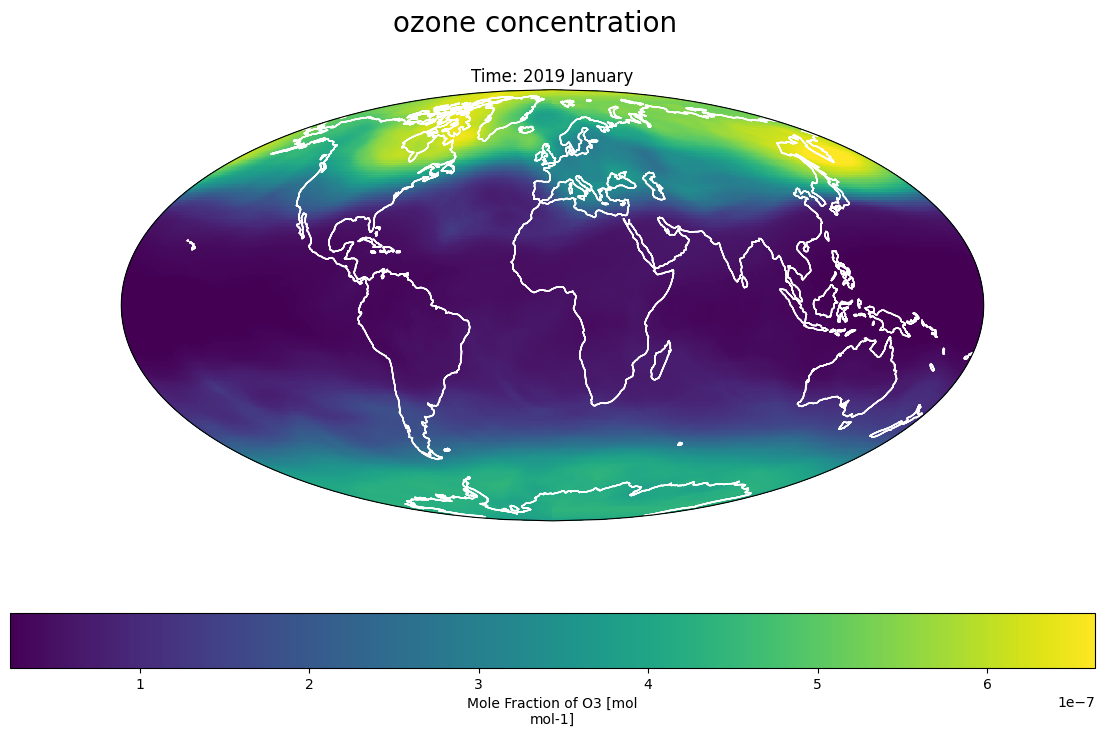

In [24]:
%%time
#plot a list of times/plevs/etc and download each one
times = np.arange(0,12*5,12)

fig = plt.figure(figsize=[14,8])
ax = plt.axes(projection=ccrs.Mollweide())
fig.suptitle('ozone concentration', size=20)
plot = ds_ozone.o3.isel(time=times[0]).sel(plev=pressurevalue).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'location':'bottom'})
for idx, t in enumerate(times):
    plot.set_array(ds_ozone.o3.isel(time=times[idx]).sel(plev=pressurevalue))
    ax.set_title('Time: %s' %timefmt(t))
    ax.coastlines(resolution='110m', color='w')
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('H:\\Summer24-25\\Jupyter\\ozone_fig%s' %str(idx), bbox_inches=extent.expanded(1.25, 1.25))

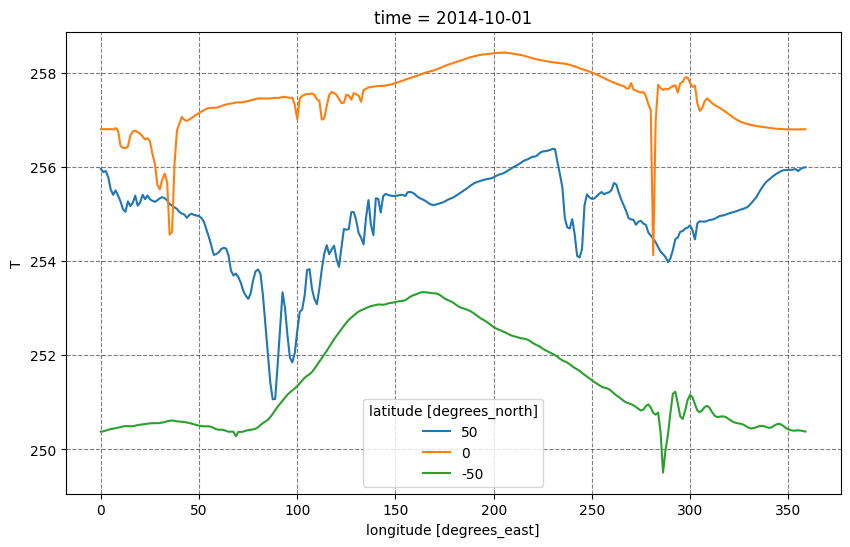

In [25]:
fig,ax = plt.subplots(figsize=[10,6])
       # taking average of levels, interpolating for latitude
ds.T.isel(time=timeindex).mean(dim='lev').interp(lat=[50,0,-50]).plot(hue='lat', ax=ax, label=[50,0,-50])
ax.grid(c='k', ls='--', alpha=0.5)

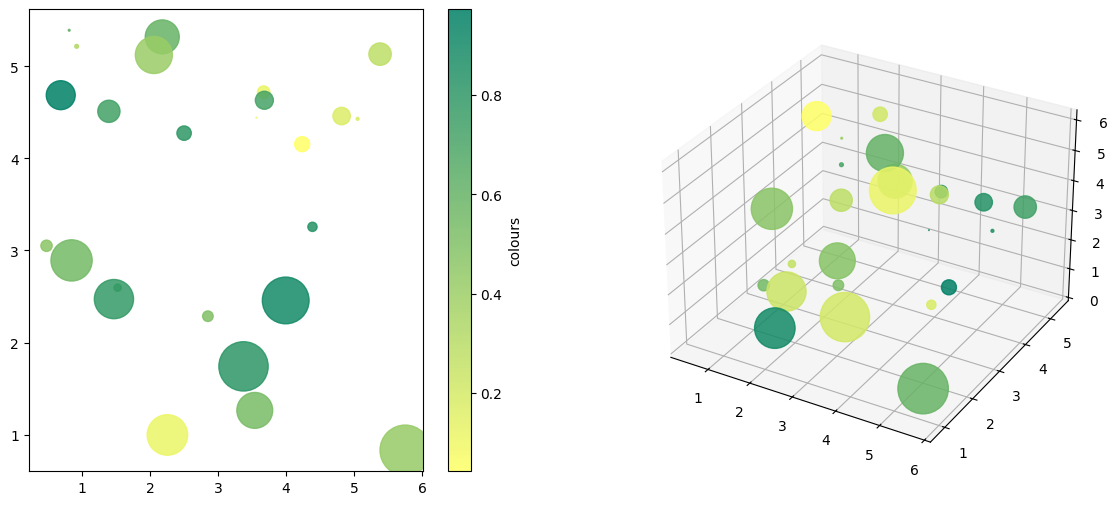

In [26]:
fig = plt.figure(figsize=[14,6])

# setting up test data
rng = np.random.default_rng()
N_points = 25

x = rng.random(N_points) * 6
y = rng.random(N_points) * 5 + 0.5
z = rng.random(N_points) * 6
area = 1.5*(30 * np.random.rand(N_points))**2  # 
c = rng.random(N_points)

# creating left plot (2D scatter)
ax_2D = fig.add_subplot(1,2,1)
left = ax_2D.scatter(x, y, s=area, c=c, alpha=0.85, cmap='summer_r') # adding '_r' to any colormap will reverse it

#creating right plot (3D scatter)
ax_3D = fig.add_subplot(1,2,2, projection='3d')
right = ax_3D.scatter(x, y, z, s=area, c=c, cmap='summer', alpha=0.85)

plt.colorbar(left, label='colours', ax=ax_2D)

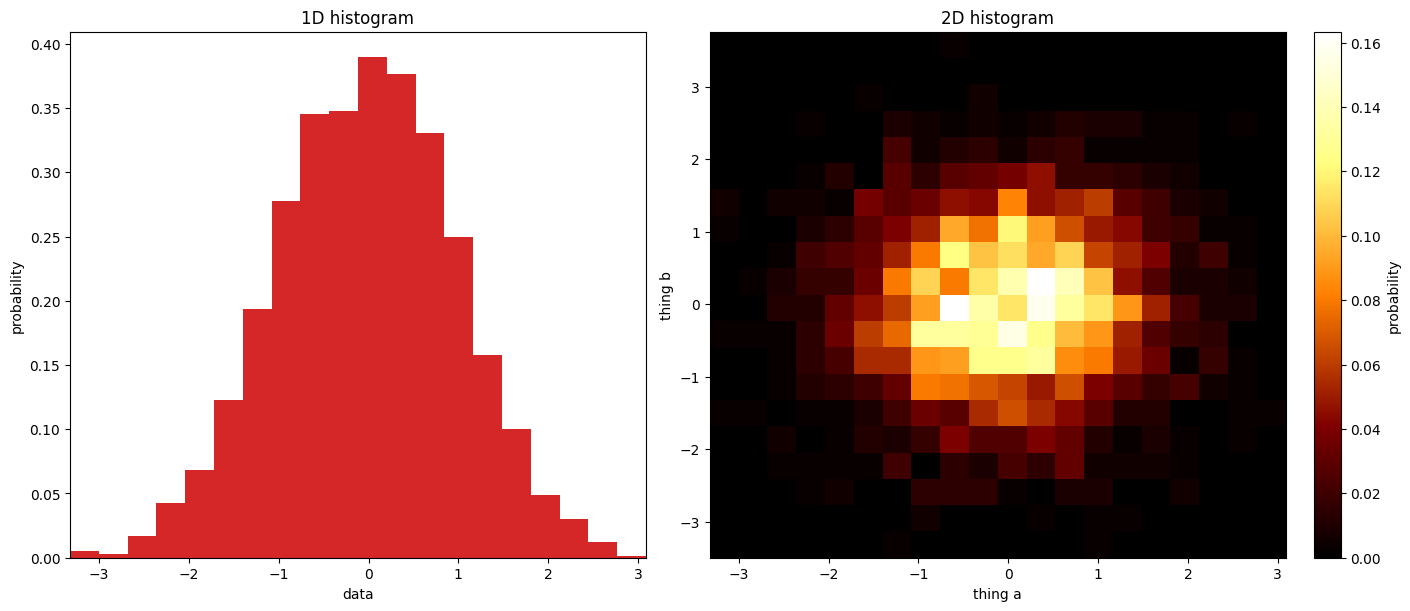

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6), layout='constrained', sharex=True)

# setting up data
npts = 3000; nbins = 20; 
x = np.random.normal(size=npts)
y = np.random.normal(size=npts)

# 1d histogram
ax1.hist(x, bins=nbins, density=True, color='tab:red')
ax1.set_title('1D histogram')
ax1.set_xlabel('data')
ax1.set_ylabel('probability')

# 2d histogram
two_d = ax2.hist2d(x, y, bins=nbins, density=True, cmap='afmhot')
ax2.set_title('2D histogram')
ax2.set_xlabel('thing a')
ax2.set_ylabel('thing b')
cb = fig.colorbar(two_d[3], ax=ax2, location='right', label='probability')

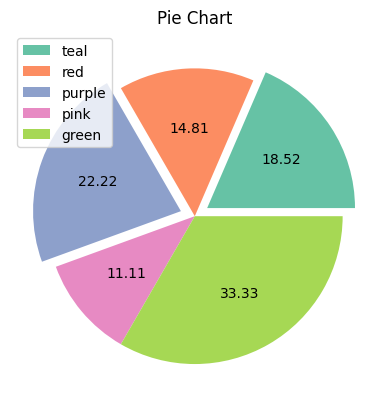

In [28]:
parts = [0.5,0.4,0.6,0.3,0.9]
colors=plt.cm.Set2.colors
labels = ['teal', 'red', 'purple', 'pink', 'green']
plt.pie(parts, colors=colors, labels=labels, labeldistance=None, explode=[0.1,0,0.1,0,0], autopct='%.2f')
plt.title('Pie Chart')
plt.legend(loc='upper left')

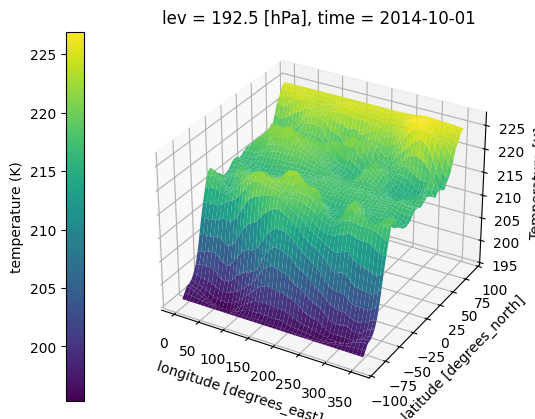

In [30]:
Temp =ds.T.isel(time=timeindex).sel(lev=pressurevalue, method='nearest')
plot = Temp.plot.surface(cmap='viridis', add_colorbar=False)
plt.colorbar(plot, location='left', label='temperature (K)')

# Further Customisation

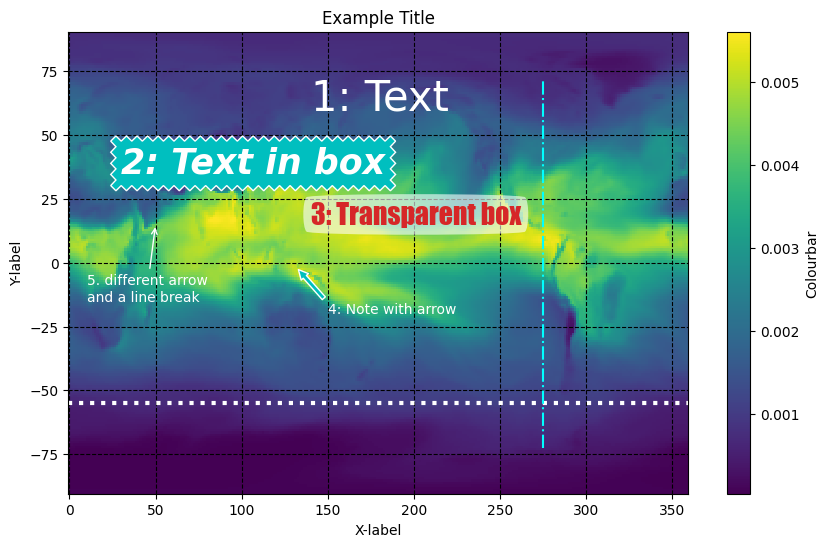

In [31]:
# Customising labels and annotating
fig, ax = plt.subplots(1,1, figsize=[10,6])
x = ds.H2O.isel(time=timeindex).mean(dim='lev').plot(ax=ax, add_colorbar=False)
ax.set(title='Example Title', ylabel='Y-label', xlabel='X-label')
fig.colorbar(x, ax=ax, label='Colourbar')

# 1. text
plt.text(x=140, y=60, s='1: Text', color='white', size=30)
# 2. text in box
plt.text(x=30, y=35, s='2: Text in box', color='w', weight='demi', style='italic', size=25, 
        bbox=dict(facecolor='c', edgecolor='w', boxstyle='sawtooth'))
# 3. transparent box
plt.text(x=140, y=15, s='3: Transparent box', size=20, font='fantasy', c='tab:red', 
        bbox=dict(fc='w', ec='none', alpha=0.6, boxstyle='round4')) # alpha controls transparency
# 4. note with arrow
ax.annotate('4: Note with arrow', xy=(132,-2), xytext=(150,-20), c='w', # xy=point of arrow, if xy=xytext, arrow disappears
            arrowprops=dict(fc='c', ec='w', shrink=0.05, width=3, headwidth=7, headlength=7))
# 5. different arrow style
ax.annotate('5. different arrow\nand a line break', xy=(50, 15), xytext=(10,-15), c='w', 
           arrowprops=dict(arrowstyle='->', color='w'))

# lines
ax.axhline(y=-55, c='w', linestyle=':', linewidth='3') #horizontal line, white, dotted line style
ax.axvline(x=275, ymin=0.1, ymax=0.9, c='cyan',ls='-.') #vertical line, starts at 10%, ends at 90%, cyan dot dash style
ax.grid(True, c='k', ls='--')

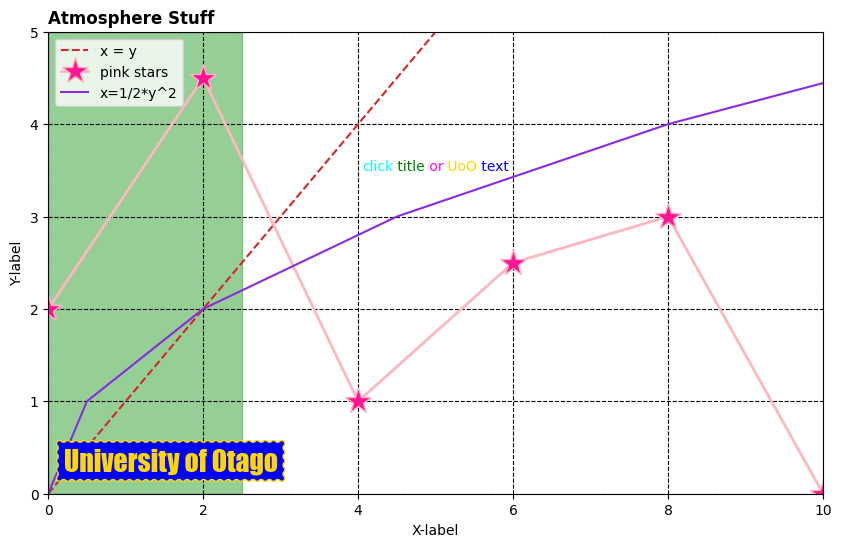

In [32]:
# Customising labels and annotating
fig, ax = plt.subplots(1,1, figsize=(10,6))

title = ax.set_title('Atmosphere Stuff', weight='bold', loc='left')
title.set_url('https://www.physics.otago.ac.nz/research/atmosphere/index.html')

ax.set(ylabel='Y-label', ylim=(0,5), xlabel='X-label', xlim=(0, 10) )
ax.grid(True, c='k', ls='--')

ax.axline([0,0], slope=1, color='tab:red', ls='--', label='x = y')

x = np.arange(0,11,2)
y = [2, 4.5, 1, 2.5, 3, 0]
ax.plot(x,y, '-*', lw=2, ms=20, mfc='deeppink', c='lightpink', label='pink stars')

y = np.arange(6)
x= 0.5*(y**2)
ax.plot(x,y, c='blueviolet', label='x=1/2*y^2')

ax.legend(loc='upper left')

rect = plt.Rectangle(xy=[0,0], width=2.5, height=5, alpha=0.5, color='tab:green')
ax.add_patch(rect)

t = ax.text(4.05, 3.5, 'click', c='cyan')
t = ax.annotate(' title', xycoords=t, xy=[1,0], verticalalignment='bottom', c='green')
t = ax.annotate(' or', xycoords=t, xy=[1,0], va='bottom', c='magenta')
t = ax.annotate(' UoO', xycoords=t, xy=[1,0], va='bottom', c='gold')
t = ax.annotate(' text', xycoords=t, xy=[1,0], va='bottom', c='blue')

link = plt.text(x=0.02, y=0.05, s='University of Otago', transform=ax.transAxes, 
        color='gold', weight='bold', font='fantasy', size=20, 
        bbox=dict(fc='blue', ec='gold', boxstyle='roundtooth'))
link.set_url('https://www.otago.ac.nz/')
fig.savefig('test.svg') #links in images only work in svg format

# Plotting Vectors

## Quiver Plots

CPU times: total: 46.9 ms
Wall time: 40.2 ms


Text(0.01, -0.1, 'January 2000')

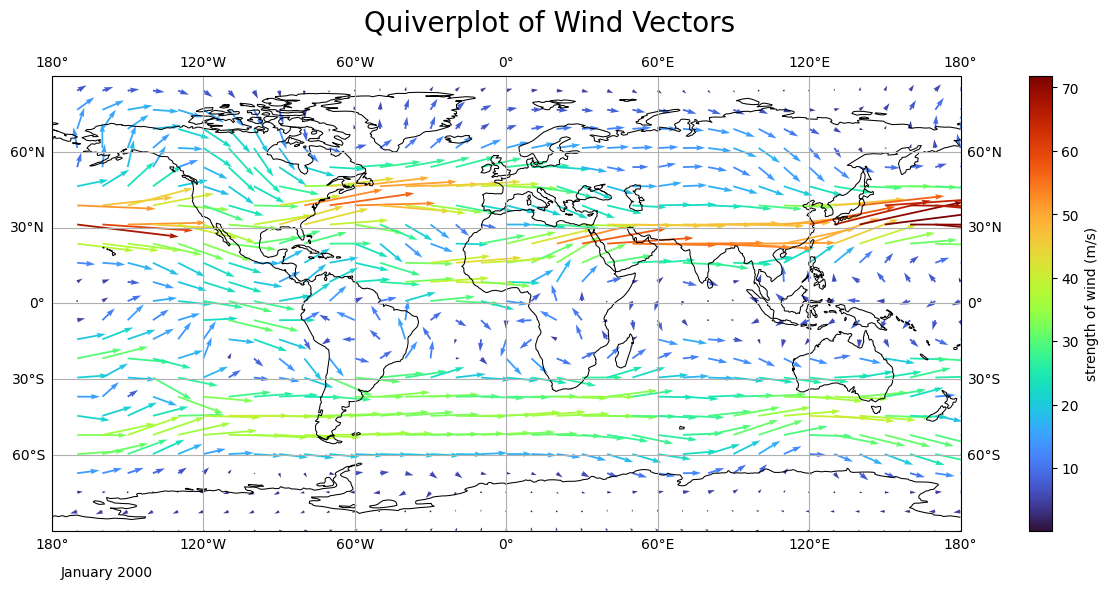

In [60]:
%%time

fig = plt.figure(figsize=(14,6), layout='tight')
ax = plt.axes(projection=ccrs.PlateCarree())
u = ds_vectors.ua.isel(time=timeindex).sel(plev=pressurevalue)[::4, ::4] # slicing to get every 4th element
v = ds_vectors.va.isel(time=timeindex).sel(plev=pressurevalue)[::4, ::4] # which loads faster + renders fewer arrows

fig.suptitle('Quiverplot of Wind Vectors', size=20)

# plain coloured arrows
# qv = ax.quiver(u.lon, u.lat, u, v, color='darkblue', scale=600, width=0.002, transform=ccrs.PlateCarree())

# arrows coloured by strength
windspeed = (v**2 + u**2)**0.5
qv = ax.quiver(u.lon, u.lat, u, v, windspeed, cmap='turbo', scale=600, width=0.002, transform=ccrs.PlateCarree())
fig.colorbar(qv, ax=ax, label='strength of wind (m/s)')

ax.coastlines(color='k', lw=0.75)
ax.gridlines(draw_labels=True)

date = dt.strptime(str(ds_vectors.time[timeindex].values), '%Y-%m-%d %H:%M:%S')
formatted = date.strftime('%B %Y')
ax.text(0.01, -0.1, formatted, ha='left', transform=ax.transAxes)

## Streamlines

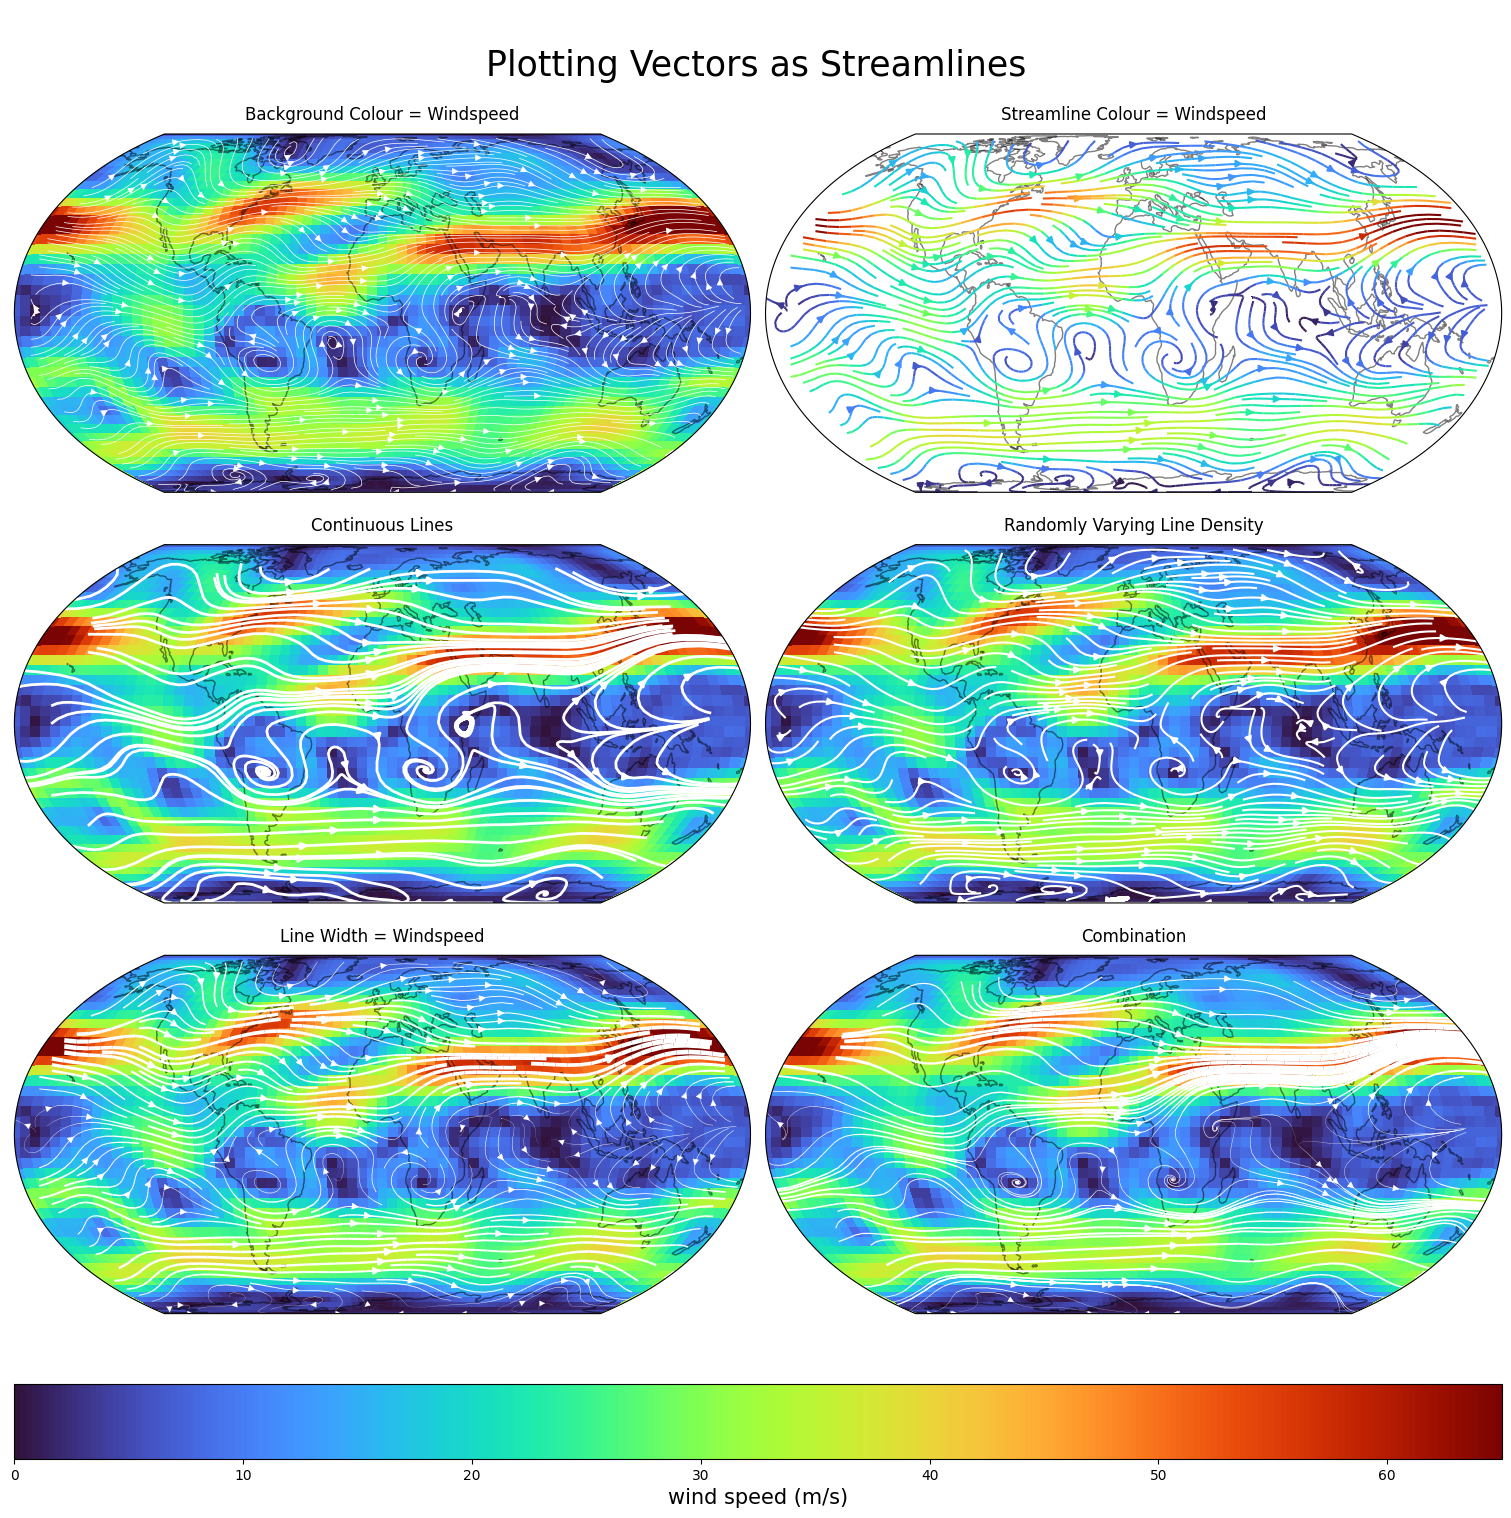

In [34]:

u = ds_vectors.ua.isel(time=timeindex).sel(plev=pressurevalue)[::2, ::2]
v = ds_vectors.va.isel(time=timeindex).sel(plev=pressurevalue)[::2, ::2]
windspeed = (u**2 + v**2)**0.5

fig, axs = plt.subplots(3,2, figsize=(15,15), layout='constrained', subplot_kw={'projection': ccrs.EqualEarth()})
fig.suptitle('\nPlotting Vectors as Streamlines', size=25)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm_wind, cmap=cmap), ax=axs, location='bottom')
cbar.set_label(label="wind speed (m/s)", size=15)

# variations of streamplots

# background colour
windspeed.plot(ax=axs[0,0], cmap=cmap, transform=ccrs.PlateCarree(), norm=cnorm_wind, add_colorbar=False)
axs[0,0].streamplot(u.lon, u.lat, u, v, transform=ccrs.PlateCarree(), density=3, color='w', linewidth=0.5)
axs[0,0].coastlines(color='k', alpha=0.5)
axs[0,0].set_title('Background Colour = Windspeed', pad=10)


# stream line colour
strm = axs[0,1].streamplot(u.lon, u.lat, u, v, transform=ccrs.PlateCarree(), density=2, color=windspeed.values, cmap=cmap, norm=cnorm_wind)
axs[0,1].coastlines(color='k', alpha=0.5)
axs[0,1].set_title('Streamline Colour = Windspeed', pad=10)


# with continuous lines
windspeed.plot(ax=axs[1,0], cmap=cmap, transform=ccrs.PlateCarree(), norm=cnorm_wind, add_colorbar=False)
axs[1,0].streamplot(u.lon, u.lat, u, v, transform=ccrs.PlateCarree(), color='w', density = 0.7, linewidth=2, broken_streamlines=False)
axs[1,0].coastlines(color='k', alpha=0.5)
axs[1,0].set_title('Continuous Lines', pad=10)


# line density--> doesn't represent wind speed!!
windspeed.plot(ax=axs[1,1], cmap=cmap, transform=ccrs.PlateCarree(), norm=cnorm_wind, add_colorbar=False)
axs[1,1].streamplot(u.lon, u.lat, u, v, transform=ccrs.PlateCarree(), density=[1,3], color='w', linewidth=1.5)
axs[1,1].coastlines(color='k', alpha=0.5)
axs[1,1].set_title('Randomly Varying Line Density', pad=10)


# line width
windspeed.plot(ax=axs[2,0], cmap=cmap, transform=ccrs.PlateCarree(), norm=cnorm_wind, add_colorbar=False)
lw = 4* (windspeed.values / windspeed.values.max())
axs[2,0].streamplot(u.lon, u.lat, u, v, transform=ccrs.PlateCarree(), color='w', linewidth=lw, density = 2)
axs[2,0].coastlines(color='k', alpha=0.5)
axs[2,0].set_title('Line Width = Windspeed', pad=10)


#combination of displays
windspeed.plot(ax=axs[2,1], cmap=cmap, transform=ccrs.PlateCarree(), norm=cnorm_wind, add_colorbar=False)
lw = 4* (windspeed.values / windspeed.values.max())
axs[2,1].streamplot(u.lon, u.lat, u, v, transform=ccrs.PlateCarree(), color='w', linewidth=lw, density = 0.75, broken_streamlines=False)
axs[2,1].coastlines(color='k', alpha=0.5)
axs[2,1].set_title('Combination', pad=10)


fig.savefig("streamlines_example") #save for higher quality image

# Animating Plots

CPU times: total: 11.9 s
Wall time: 12.7 s


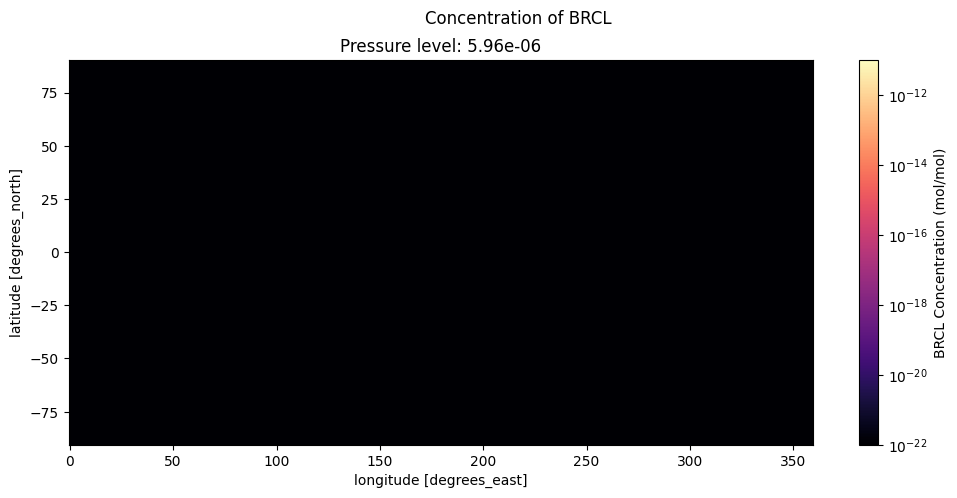

In [35]:
%%time

# Good animation without coastlines
data = ds.BRCL.isel(time=timeindex)
fig,ax = plt.subplots(figsize=(12,5))
fig.suptitle('Concentration of BRCL', ha='center')

norm = mpl.colors.LogNorm(vmin=10**-22, vmax=10**-11) # the range of colorbar--> figure out through looking at data
plot = data.isel(lev=0).plot.pcolormesh(ax=ax, cmap='magma', norm=norm, extend='both', add_colorbar=False) # plot initial figure
fig.colorbar(plot, label='BRCL Concentration (mol/mol)')

def animate(num): # function to update each frame
    plot.set_array(data.isel(lev=num))
    ax.set_title('Pressure level: %.4g' %ds.lev.isel(lev=num)['lev'].values)

anim = animation.FuncAnimation(fig, animate, frames=ds.BRCL.lev.size, interval=200) # frames = number frames to draw, interval = speed of anim

anim.save('brcl_norm.gif', writer='pillow'); # save animation to same folder as jupyter file

# 18.8 s ± 717 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

CPU times: total: 21.2 s
Wall time: 22 s


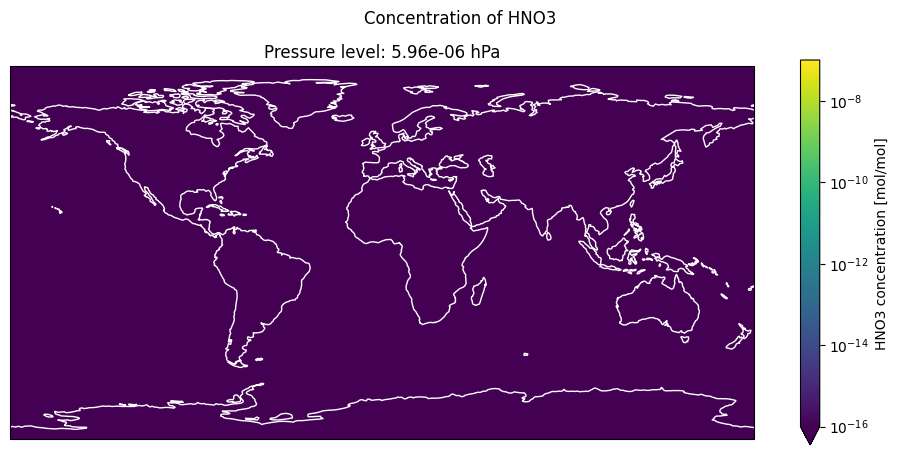

In [36]:
%%time
# contourf animation with cartopy coastlines
data = ds.HNO3.isel(time=timeindex)
fig = plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.PlateCarree())

fig.suptitle('Concentration of HNO3', ha='center')

norm = mpl.colors.LogNorm(vmin=10**-16, vmax=10**-7) # normalise so frames share same range of colors -> figure range through testing
plot = data.isel(lev=0).plot(ax=ax, norm=norm, transform=ccrs.PlateCarree()) # initial plot, creates colorbar

def animate(num): # animation func updates for each frame
    ax.clear() # clear previous frame
    colorby, lons = cutil.add_cyclic_point(data.isel(lev=num), coord=ds.lon) # tells map that longitude is cyclic--> stops white bar appearing
    cs = ax.contourf(lons, ds.lat, colorby, norm=norm, levels=10, transform=ccrs.PlateCarree()) # draw plot
    ax.coastlines(color='w') # draw coastlines
    ax.set_title('Pressure level: %.4g hPa' %ds.lev.isel(lev=num)['lev'].values) # title frame with current pressure level


anim = animation.FuncAnimation(fig, animate, frames=ds.HNO3.lev.size, interval=200, repeat=True) # frames= number frames in anim, interval = frame per time

anim.save('HNO3_cartopy.gif', writer='pillow'); # save animation to same folder as jupyter file

# 21.6 s ± 318 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

CPU times: total: 27min 57s
Wall time: 28min


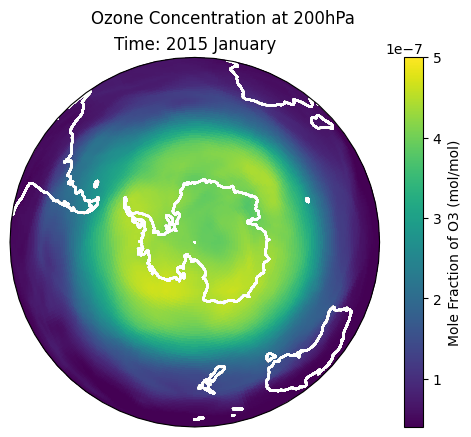

In [37]:
%%time
## normalised colours + coasts
data = ds_ozone.o3.sel(plev=pressurevalue)

fig = plt.figure()
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=-90))

fig.suptitle("Ozone Concentration at %shPa" %pressurevalue)
plot = data.isel(time=timeindex).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), norm=cnorm_o3, extend='both', add_colorbar=False)
fig.colorbar(plot, label='Mole Fraction of O3 (mol/mol)')

def animate(num):
    plot.set_array(data.isel(time=num))
    ax.set_title("Time: %s" %timefmt(num))
    ax.coastlines(color='w', lw=1.5, resolution='110m')
    

anim = animation.FuncAnimation(fig, animate, interval=200, frames=ds_ozone.o3.time.size)
anim.save("o3_normCoasts_full.gif", writer='pillow')

CPU times: total: 1min 11s
Wall time: 1min 14s


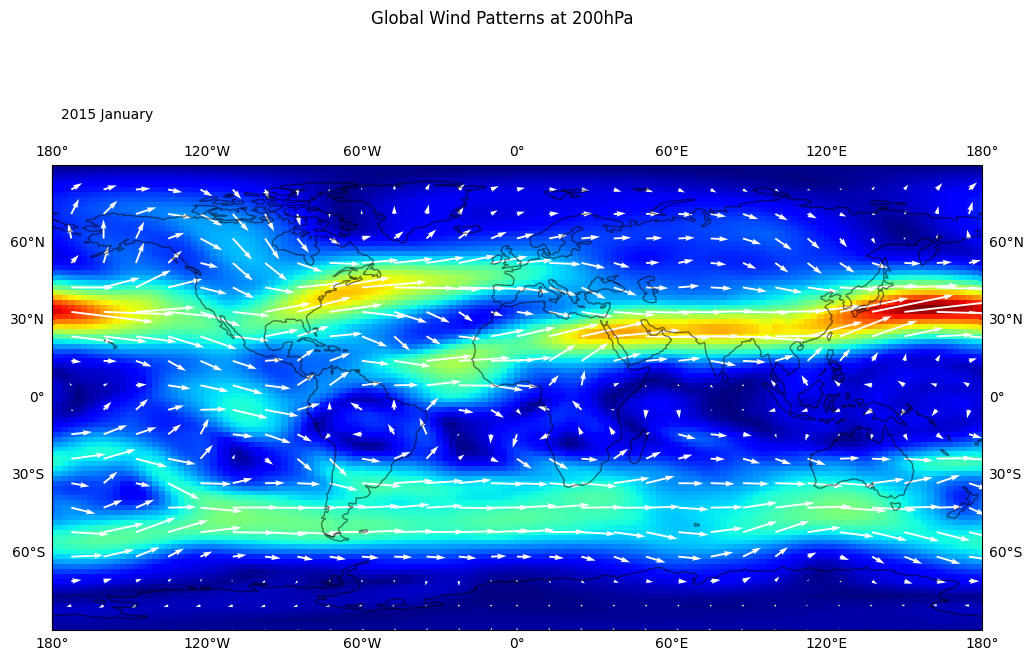

In [38]:
%%time

data=ds_vectors.sel(plev=pressurevalue)

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
fig.suptitle('Global Wind Patterns at %shPa' %pressurevalue)

def animate(num):
    ax.clear()
    u = data.ua.isel(time=num)
    v = data.va.isel(time=num)
    
    windspeed = (u**2 + v**2)**0.5
    windspeed.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='jet', add_colorbar=False)

    u = u[::5, ::5]# slicing to get every 5th element
    v = v[::5, ::5]
    
    qv = ax.quiver(u.lon, u.lat, u, v, transform=ccrs.PlateCarree(), scale=800, width=0.002, color='w')
    
    ax.text(0.01, 1.1, timefmt(num), ha='left', transform=ax.transAxes)
    ax.set_title('')
    ax.coastlines(color='k', alpha=0.5)
    ax.gridlines(draw_labels=True, color='none')
    

ani = animation.FuncAnimation(fig, animate, interval=200, frames=ds_vectors.ua.time.size)
ani.save('wind_qv_background.gif', writer='pillow')

# Interactive Plots

## Holoviews Plots

In [39]:
data = ds_ozone.o3.isel(time=slice(0,24), plev=slice(6,11))
## Interactive with holoview interface, less work but slower and less control
hv.output(widget_location='bottom')

graph = data.hvplot(
    'lon', 'lat', projection=ccrs.Orthographic(90), global_extent=True, project=True, 
    cmap='turbo', coastline=True, size=500, cnorm='log', clim=(2*10**-8, 9*10**-7)
)

# hvplot.save(graph, 'graph.html') ##use html to be able to interact, then use the save tool within file to save specific time/plev
graph

:DynamicMap   [time,plev]
   :Overlay
      .Image.I     :Image   [lon,lat]   (Mole Fraction of O3)
      .Coastline.I :Feature   [Longitude,Latitude]

In [52]:
data = ds_ozone.o3.isel(time=slice(0,12), plev=slice(6,11))
graph = data.hvplot('lon','lat', projection=ccrs.EqualEarth(), project=True, coastline=True, size=600, cnorm='log')
path = hv.Path([])
freehand = streams.FreehandDraw(source=path, num_objects=5)
path.opts(active_tools=['freehand_draw'], height=500, line_width=5, width=1000, color='r')
# hvplot.save(graph*path, 'earth-draw.html')
hvplot.show(graph*path)

Launching server at http://localhost:63047


## Matplotlib Interactive Plots

The default matplotlib backend doesn't work interactively, so we must change it. The options for this are generally: qt / qtagg or tk / tkagg. 
Implement this using %matplotlib qt or %matplotlib tk at the top of whichever cell you are using. This will set it from then on, so when you want to go back to the normal inline plots, use %matplotlib inline

Select label locations manually using first mouse button.
End manual selection with second mouse button.


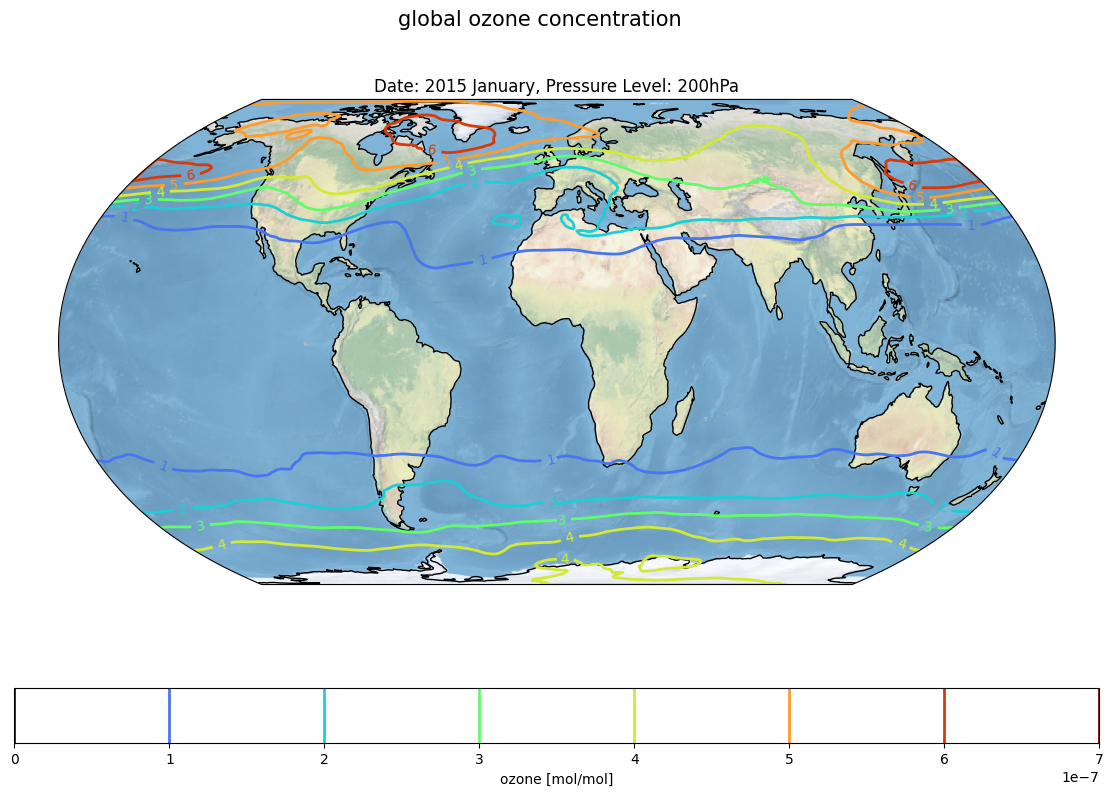

In [57]:
### Only needed for custom contour labels ###
%matplotlib qt
# location based scalar data

size = fig_dimensions
time = timeindex
plev = pressurevalue
data = ds_ozone.o3.isel(time=time).sel(plev=plev)

## Plotting
fig = plt.figure(figsize=size)
ax = plt.axes(projection=ccrs.EqualEarth())
data, lons = cutil.add_cyclic_point(data, coord=ds.lon) #else would be a white line in middle
graph = ax.contour(lons, ds.lat, data, transform=ccrs.PlateCarree(), levels=6, linewidths=2, cmap=cmap)
colorbar = fig.colorbar(graph, ax=ax, location='bottom')
ax.coastlines(color='k', linewidth=1)
ax.stock_img()

## labels/words
fig.suptitle(t='click for label, middle button to save and exit', size=15) ### Only needed for custom contour labels ###
labels = plt.clabel(graph, manual=True) #place custom contour lines (must have %matplotlib qt at top of cell)

colorbar.set_label(label='ozone [mol/mol]', size=10)
fig.suptitle(t='global ozone concentration', size=15)
ax.set_title(label='Date: %s, Pressure Level: %.fhPa' %(timefmt(time), plev))

### Only needed for custom contour labels ###
%matplotlib inline

# save figure
fig.savefig('H:\\Summer24-25\\Jupyter\\Plots_download\\ozone_conc.png')

plt.show()

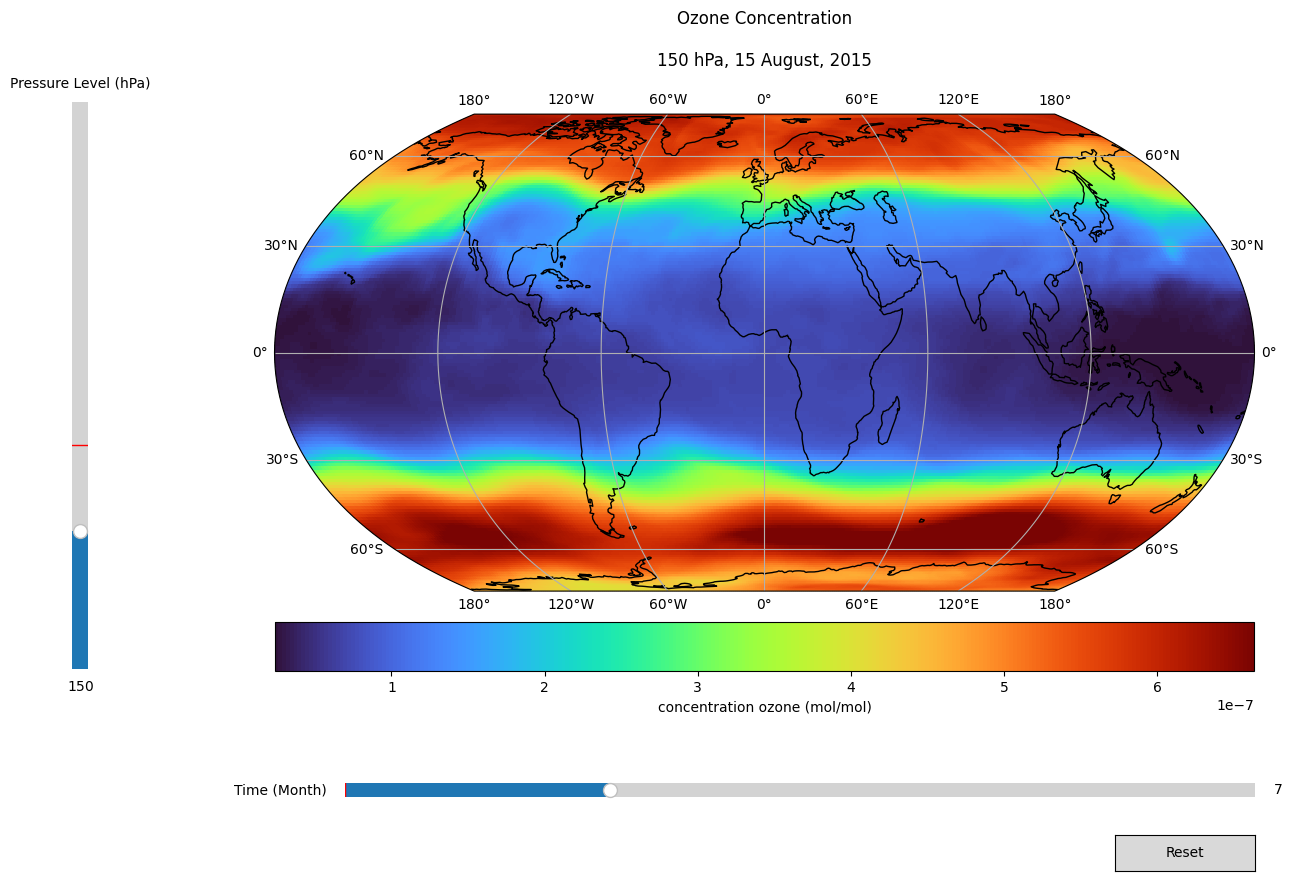

In [58]:
%matplotlib qt
## Interactive with matplotlib interface, more work but better control
## adapted from https://matplotlib.org/stable/gallery/widgets/slider_demo.html and https://matplotlib.org/stable/gallery/widgets/slider_snap_demo.html
init_plev = pressurevalue
init_time = timeindex
size = fig_dimensions
 
 
c = cmap

fig = plt.figure(figsize=size)
ax = fig.add_subplot(projection=ccrs.EqualEarth())
ax.coastlines()
ax.gridlines(draw_labels=True)

graph = ds_ozone.o3.isel(time=init_time).sel(plev=init_plev).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=c, add_colorbar=False)
cbar = fig.colorbar(graph, ax=ax, location='bottom', label='concentration ozone (mol/mol)', pad=0.05)
ax.set_title('Date: %s' %timefmt(init_time))
fig.subplots_adjust(left=0.2, bottom=0.2)

# horizontal slider --> time
axtime = fig.add_axes([0.25, 0.1, 0.65, 0.03])
time_slider = Slider(ax=axtime, label='Time (Month)', valmin=0, valmax=24, valstep=1, valinit=init_time,)

# vertical slider -> plev
axplev = fig.add_axes([0.05, 0.25, 0.0225, 0.63])
plev_slider = Slider(ax=axplev, label='Pressure Level (hPa)', valmin=70, valmax=400, 
                     valstep=ds_ozone.plev, valinit=init_plev, orientation="vertical",)

def update(val):
    graph.set_array(ds_ozone.o3.isel(time=time_slider.val).sel(plev=plev_slider.val))
    ax.set_title('Date: %s' %timefmt(time_slider.val))
    fig.canvas.draw_idle()

def reset(event):
    time_slider.reset()
    plev_slider.reset()

def close():
    %matplotlib inline
    fig.suptitle('')
    ax.set_title('Ozone Concentration\n\n%.f hPa, %s'%(plev_slider.val, timefmt(time_slider.val, '%d %B, %Y')), pad=20)
    extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('H:\\Summer24-25\\Jupyter\\TEST.png', bbox_inches=extent.expanded(1.1, 1.4)) # only saves the plot, not sliders and button
    plt.show()

# register the update function with each slider
time_slider.on_changed(update)
plev_slider.on_changed(update)

# make button to reset sliders to init_values
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
reset_button = Button(resetax, 'Reset', hovercolor='0.975')
reset_button.on_clicked(reset)

while True:
    fig.suptitle('press any key to save and exit')
    if plt.waitforbuttonpress():
        close()
        break

In [59]:
%matplotlib inline

# Sources

* https://foundations.projectpythia.org
* https://matplotlib.org/stable/users/index.html
* https://matplotlib.org/stable/gallery/index.html
* https://matplotlib.org/3.5.0/tutorials/
* https://docs.xarray.dev/en/stable/user-guide/plotting.html
* https://metos-uio.github.io/GEO4962/04-Simple_plot/index.html
* https://www.naturalearthdata.com/downloads/
* https://scitools.org.uk/cartopy/docs/latest/reference/projections.html
* https://kpegion.github.io/Pangeo-at-AOES/index.html
* https://docs.python.org/3/library/
* https://holoviews.org/user_guide/